In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib as mp
from functools import reduce


In [2]:
#Import all csv files of VCF
files = glob.glob('G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\\Genomics\\M145 Evolved mutants\\*.csv')

strain_names = list(map(lambda f: f.split('\\')[6].split('_')[0], files))
vcfs = dict()
for (strain, file) in zip(strain_names, files):
    vcf = pd.read_csv(file)
    vcf['Variant Frequency']= list(map(lambda x: float(x[0].replace('%', ''))/100, vcf['Variant Frequency'].str.split( '->')))
    vcf.sort_values(by = ['Variant Frequency'], ascending = False, inplace = True)
    vcfs[strain] = vcf
    
    
vcfs['WT'].head(5)

,Name,Minimum,Maximum,Length,# Intervals,CDS Position,Change,Coverage,locus_tag,Polymorphism Type,Protein Effect,Variant Frequency,Variant P-Value (approximate),Amino Acid Change,Codon Change,Sequence,gene,note
0,G,104233,104233,1,1,606.0,A -> G,34,SCO0124,SNP (transition),None,1.0,1.000000e-102,NaN,GAA -> GAG,A,NaN,"SCJ21.05, unknown, len: 453 aa; similar in par..."
29,C,7118314,7118314,1,1,61.0,G -> C,20,SCO6436,SNP (transversion),Substitution,1.0,1.000000e-62,V -> L,GTG -> CTG,G,NaN,"SC9B5.03, probable tRNA synthetase, len: 506 a..."
22,G,5633841,5633841,1,1,19.0,C -> G,20,SCO5182,SNP (transversion),Substitution,1.0,1.000000e-54,R -> G,CGC -> GGC,C,NaN,"2SC3B6.06, conserved hypothetical protein, len..."
23,NaN,5643986,5643986,1,1,601.0,(G)3 -> (G)2,47,SCO5186,Deletion (tandem repeat),Frame Shift,1.0,3.200000e-71,NaN,NaN,G,NaN,"2SC3B6.10, conserved hypothetical protein, len..."
24,NaN,5753681,5753681,1,1,NaN,-C,42,NaN,Deletion,NaN,1.0,2.500000e-97,NaN,NaN,C,NaN,NaN


In [3]:
# Simplify the vcfs by selecting columns 'Name', 'Minimum', 'Maximum', 'Sequence', 'Variant Frequency', 'locus_tag', 'note'
cols = ['Name', 'Minimum', 'Maximum', 'Sequence', 'Variant Frequency', 'locus_tag', 'note']
def simplify_vcfs(vcfs, cols):
    vcfs_s = dict()
    for key in vcfs:
        vcfs_s[key] = vcfs[key].loc[:, cols]
    return vcfs_s

In [4]:
vcfs_s = simplify_vcfs(vcfs,cols)
vcfs_s['R1'].head(5)

,Name,Minimum,Maximum,Sequence,Variant Frequency,locus_tag,note
0,G,619172,619172,C,1.0,SCO0577,"SCF55.01c, hypothetical protein, len: >231 aa;..."
22,G,4397330,4397330,C,1.0,NaN,NaN
24,G,4726818,4726818,C,1.0,SCO4315,"SCD95A.48, possible homeostasis protein, len: ..."
25,G,4912786,4912785,-,1.0,SCO4493,"SCD69.13, probable asnC-family transcriptional..."
26,G,5107398,5107398,C,1.0,SCO4676,"SCD31.01c, unknown (fragment), len: >147 aa; S..."


In [5]:
#Find all variance in mutants with 100% Variant Frquency 
def diff2ref_100_in_mutants(vcfs_s):
    '''
    input: vcfs_s, dictionary of simplified variant files of all mutants and WT compared to the ref genome;
           
    output: dictionary of variant files of mutants with 100% variant freq, the WT file is unchanged
    '''
    vcfs_100 =  dict()
    for key in vcfs_s:
        vcf = vcfs_s[key]
        vcf['locus_tag'].fillna('intergenetic region', inplace = True)
        if key != 'WT':
            vcfs_100[key] = vcf[vcf['Variant Frequency'] == 1].set_index(['Minimum', 'Maximum', 'Name'])
        else:
            vcfs_100[key] = vcf.set_index(['Minimum', 'Maximum', 'Name'])
    return vcfs_100


In [6]:
vcfs_100 = diff2ref_100_in_mutants(vcfs_s)
vcfs_100['R1'].head(5)

,,,Sequence,Variant Frequency,locus_tag,note
Minimum,Maximum,Name,,,,
619172,619172,G,C,1.0,SCO0577,"SCF55.01c, hypothetical protein, len: >231 aa;..."
4397330,4397330,G,C,1.0,intergenetic region,NaN
4726818,4726818,G,C,1.0,SCO4315,"SCD95A.48, possible homeostasis protein, len: ..."
4912786,4912785,G,-,1.0,SCO4493,"SCD69.13, probable asnC-family transcriptional..."
5107398,5107398,G,C,1.0,SCO4676,"SCD31.01c, unknown (fragment), len: >147 aa; S..."


In [7]:
# Find all 100% appeared variance in mutant strains, pick up the 'Minimum', 'Maximum' and 'Name' as the mark for the variance
def find_diff_100(vcfs_100):
    '''
    input: simplified vcfs with difference 100% appeared in mutants
    output: diff, all nonredundant diff in all mutants;
    '''
    strains = list(vcfs_100.keys())
    df = vcfs_100[strains[0]]
    for strain in strains[1:-1]:
        df = df.append(vcfs_100[strain])
    return list(set(df.index.values))

In [8]:
diff = find_diff_100(vcfs_100)
diff[0]

(6769995, 6769995, 'C')

In [9]:
variance_table = pd.DataFrame(index = diff, columns = strain_names)
variance_table['WT VF'] = np.nan
for strain in strain_names:
    vcf = vcfs_100[strain]
    strain_inds = vcf.index.values
    if strain != 'WT':
        for ind in strain_inds:
            if ind in diff:
                variance_table.loc[ind, strain] = 1            
    else:
        for ind in strain_inds:
            # For WT strain, there are two cases:
            # Case one: the exactly the same diff (locus and change) in WT is found in mutants-- preexisted change didn't evolve 
            # Case two: the diff site in WT is the same as in mutants, but the change is different-- preexisted change evolve again in mutants
            for d in diff:
                if ind == d:
                    variance_table.loc[d,'WT VF'] = round(vcf.loc[ind, 'Variant Frequency'], 2)
                    variance_table.loc[d, strain] = 1   
                elif ind[0:2] == d[0:2] and ind[2] != vcf.loc[ind, 'Sequence']:
                    variance_table.loc[d,'WT VF'] = round(vcf.loc[ind, 'Variant Frequency'], 2)
                    variance_table.loc[d, strain] = 1
                          
variance_table = variance_table.fillna(0).sort_index()


In [10]:
# save variance_table as csv
filepath = "G:\\Ye\\Evolution mutants\\variance_table.csv"
cols = variance_table.columns.values
df = variance_table.loc[:, cols[:-2]]
df.to_csv(filepath)
df

,R1,R2,R3,R4,R5,RH1,RH2,RH5,W1,W2,W3,W4,W5,WS1,WS2
"(104233, 104233, G)",0,1,0,1,1,0,0,1,1,1,1,1,1,0,1
"(603360, 603360, G)",0,0,1,1,0,0,0,1,0,0,0,0,1,1,1
"(619172, 619172, G)",1,1,0,1,1,0,0,1,1,0,0,0,0,1,1
"(657081, 657081, G)",1,1,1,1,1,0,0,1,0,1,1,0,1,0,1
"(676029, 676028, C)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
"(719015, 719015, A)",0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
"(1246835, 1246835, G)",1,0,0,0,0,0,1,0,0,1,1,0,0,0,0
"(1415134, 1415134, G)",1,0,0,1,1,0,0,1,1,1,1,1,0,1,1
"(1523375, 1523376, GT)",0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
"(1587068, 1587068, G)",0,0,0,1,0,1,0,1,1,0,1,1,1,0,1


In [11]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [12]:
def venn_WT_Mutant(variance_table, mutant_name):
    comp_table = variance_table[[mutant_name, 'WT']]
    strain_num = comp_table.aggregate('sum')
    common_diff_num = sum(comp_table.sum(axis = 1) == 2)
    venn2(subsets = (strain_num[mutant_name], strain_num['WT'], common_diff_num), set_labels = (mutant_name, 'WT'))
    plt.show()

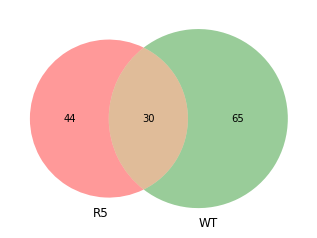

In [13]:
venn_WT_Mutant(variance_table, 'R5')

C:\Users\yxu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


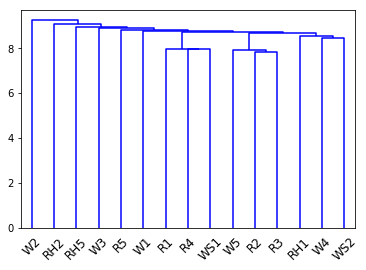

In [14]:
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
cols = variance_table.columns.values
df = variance_table.loc[:, cols[0:-2]].transpose()
Y = pdist(df, 'euclidean')
dist_mat = squareform(Y)
linkage_matrix = linkage(dist_mat, "single")
dendrogram(linkage_matrix, color_threshold=1, labels=cols[0:-2],show_leaf_counts=True, leaf_rotation = 45)
plt.title=("test")
plt.show()

In [15]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
base = importr("base")
pvclust = importr("pvclust")
data = robjects.DataFrame.from_csvfile("G:\\Ye\\Evolution mutants\\variance_table.csv")
#result = pvclust.pvclust(df, nboot=100, method_dist="correlation", method_hclust="average")

data.head(5)
cols = robjects.IntVector(range(2,17))

subset = data.rx(True, cols)
subset.head(5)
result = pvclust.pvclust(subset, nboot=1000, method_dist="correlation", method_hclust="single")


In [16]:
graphics = importr("graphics")
grdevices = importr("grDevices")
#grdevices.pdf("G:\\Ye\\Evolution mutants\\evolveMutants_phylo_boot1000.pdf", paper="a4")
graphics.plot(result)
#grdevices.dev_off()

rpy2.rinterface.NULL

In [17]:
def find_variance_by_mutant(variance_table, mutant_name):
    variance = variance_table[mutant_name].where(variance_table[mutant_name] == 1).dropna().index.values
    variance = vcfs_100[mutant_name].loc[variance, ['locus_tag', 'note']]
    variance_genes = variance.dropna().reset_index(drop = True).set_index('locus_tag').drop_duplicates()
    return variance, variance_genes



In [169]:
# Only look at genes
variance_full, variance_genes = find_variance_by_mutant(variance_table, 'WT') 
variance_full

,,,locus_tag,note
Minimum,Maximum,Name,,
104233,104233,G,SCO0124,"SCJ21.05, unknown, len: 453 aa; similar in par..."
603360,603360,G,intergenetic region,NaN
619172,619172,G,SCO0577,"SCF55.01c, hypothetical protein, len: >231 aa;..."
657081,657081,G,SCO0617,"SCF56.01c, hypothetical protein (partial CDS),..."
676029,676028,C,intergenetic region,NaN
1523375,1523376,GT,SCO1428,"SC6D7.11, acd, acyl-CoA dehydrogenase (EC 1.3...."
1587068,1587068,G,SCO1483,four CarB-CarA dimers form the carbamoyl phosp...
1616266,1616265,G,SCO1511,"SCL2.01, hypothetical protein (fragment), len:..."
1616552,1616552,G,intergenetic region,NaN


In [19]:
def find_hot_variance(variance_table, hot_thresh):
    cols = variance_table.columns.values
    df = variance_table.loc[:, cols[:-2]]
    hits = df.sum(axis = 1).sort_values(ascending = False) 
    hot_variance = hits[hits >= hot_thresh].index.values
    return hot_variance
  

In [20]:
def find_hot_variance_by_mutant(variance_table, mutant_name, hot_thresh):
    hots = find_hot_variance(variance_table,hot_thresh)
    variance_full, variance_genes = find_variance_by_mutant(variance_table, mutant_name) 
    var_mutant = variance_full.index.values
    intersection = list(set(hots).intersection(var_mutant))
    hots_mut = variance_full.loc[intersection, ['locus_tag', 'note']]
    return hots_mut.dropna()[['locus_tag', 'note']].drop_duplicates().sort_values(by = 'locus_tag')

In [21]:
find_hot_variance_by_mutant(variance_table, 'W2', 10)

,,,locus_tag,note
Minimum,Maximum,Name,,
104233,104233,G,SCO0124,"SCJ21.05, unknown, len: 453 aa; similar in par..."
657081,657081,G,SCO0617,"SCF56.01c, hypothetical protein (partial CDS),..."
1415134,1415134,G,SCO1337,"2SCG61.19c, possible oxidoreductase, len: 301 ..."
3349264,3349264,C,SCO3055,"SCBAC19G2.10, conserved hypothetical protein, ..."
5643986,5643986,NaN,SCO5186,"2SC3B6.10, conserved hypothetical protein, len..."
7044234,7044234,G,SCO6381,"SC4A2.17c, probable lipoprotein, len: 447 aa; ..."
7364061,7364061,C,SCO6635,"SC4G2.09, pglY, len: 1294 aa; 99.8% identical ..."


In [22]:
def find_cold_variance(variance_table, cold_thresh):
    cols = variance_table.columns.values
    df = variance_table.loc[:, cols[:-2]]
    hits = df.sum(axis = 1).sort_values(ascending = False) 
    cold_variance = hits[hits < cold_thresh].index.values
    return cold_variance

In [23]:
def find_cold_variance_by_mutant(variance_table, mutant_name, cold_thresh):
    colds = find_cold_variance(variance_table,cold_thresh)
    variance_full, variance_genes = find_variance_by_mutant(variance_table, mutant_name) 
    var_mutant = variance_full.index.values
    intersection = list(set(colds).intersection(var_mutant))
    colds_mut = variance_full.loc[intersection, ['locus_tag', 'note']]
    return colds_mut.dropna()[['locus_tag', 'note']].drop_duplicates().sort_values(by = 'locus_tag')

In [24]:
find_cold_variance_by_mutant(variance_table, 'W2', 3)

,,,locus_tag,note
Minimum,Maximum,Name,,
719015,719015,A,SCO0676,"SCF91.36, possible integral membrane sensor pr..."
1625888,1625888,A,SCO1520,endonuclease; resolves Holliday structures; fo...
4257066,4257067,GA,SCO3869,"SCH18.06, probable WD-40 repeat protein, len: ..."
5018293,5018293,G,SCO4595,"SCD20.13c, probable oxidoreductase, len: 645 a..."


In [97]:
# Read pathway cluster file 
pathways = pd.read_excel("G:\\Ye\\Evolution mutants\\Gene clusters in coelicolor.xlsx")
pathways.head(5)


,Biosynthetic system,Metabolite,"Size, kb",Location
0,Type II PKS,Actinorhodin,22.0,5071—5092
1,Type II PKS,Gray spore pigment,8.0,5314—5320
2,Mixed,Methylenomycin,20.0,SCP1 plasmid
3,NRPS; type I modular PKS,Prodiginines,33.0,5877—5898
4,NRPS,CDA,80.0,3210—3249


In [143]:
pathways_coe = pathways.drop(2).reset_index()

In [144]:
locations = pathways_coe['Location'].apply(str).str.split('—')
short_inds = locations[locations.apply(len) == 1].index.values
for pos in short_inds:
    val = int(locations.iloc[pos][0])
    locations.iloc[pos] = [val, val]
    


In [145]:
pathways_coe['location'] = locations
pathways_coe = pathways_coe.drop(columns = ['index', 'Location'])

In [146]:
pathways_coe

,Biosynthetic system,Metabolite,"Size, kb",location
0,Type II PKS,Actinorhodin,22.0,"[5071, 5092]"
1,Type II PKS,Gray spore pigment,8.0,"[5314, 5320]"
2,NRPS; type I modular PKS,Prodiginines,33.0,"[5877, 5898]"
3,NRPS,CDA,80.0,"[3210, 3249]"
4,NRPS,Coelichelin,20.0,"[0489, 0499]"
5,NRPS,Coelibactin,26.0,"[7681, 7691]"
6,NRPS,Unknown,14.0,"[6429, 6438]"
7,Type I modular PKS,Unknown,70.0,"[6273, 6288]"
8,Type I modular PKS,Unknown,10.0,"[6826, 6827]"
9,Type I iterative PKS,Polyunsaturated fatty acid?,19.0,"[0124, 0129]"


In [150]:
pathways_coe.loc[0,'location']

'5071'

In [151]:
variance_R1 = find_hot_variance_by_mutant(variance_table, 'R1', 1)
locus_R1 = variance_R1['locus_tag'].str.lstrip('SCO')
locus_ranges = pathways_coe['location']
for pos in locus_R1:
    pos = int(pos)
    for locus in locus_ranges:
        if pos in range(int(locus[0]), int(locus[1])):
            print(locus, pos)
          

['6429', '6438'] 6436


In [153]:
def find_pathway_hits(variance_table, mutant_name, hot_thresh, pathways_coe):
    variance_mut = find_hot_variance_by_mutant(variance_table, mutant_name, hot_thresh)
    locus_mut = variance_mut['locus_tag'].str.lstrip('SCO')
    locus_ranges = pathways_coe['location']
    for pos in locus_mut:
        pos = int(pos)
        for locus in locus_ranges:
            if pos in range(int(locus[0]), int(locus[1])):
                print(locus, pos)

In [174]:
find_pathway_hits(variance_table, 'WS2', 1, pathways_coe)

['0124', '0129'] 124
['6429', '6438'] 6436
